In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from pathlib import Path
from datetime import date
from tensorflow.keras.preprocessing import image

In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BASE_LOG_PATH = './logs/'
BATCH_SIZE = 64
LAST_TRAINABLE_LAYERS = 8
# LR = 0.000001
LR = 0.000001
MODEL_TYPE = 'regression'
TIME = str(date.today()).replace(" ", "-")
# LOG_DIR = f"{BASE_LOG_PATH}{MODEL_TYPE}/test"
LOG_DIR = f"{BASE_LOG_PATH}{MODEL_TYPE}/{TIME}_batch_{BATCH_SIZE}_lr_{LR}_2p_layers_{LAST_TRAINABLE_LAYERS}"
print(f"Logging to {LOG_DIR}")
tensorboard_callback = TensorBoard(log_dir=LOG_DIR)

Logging to ./logs/regression/2021-02-10_batch_64_lr_1e-06_2p_layers_8


In [4]:
BASE_PATH = Path("../data/regression")
train = pd.read_csv( BASE_PATH / 'train_gt.csv')
train = train.drop(columns=['stdv'])
train["imagepath"] = BASE_PATH / 'train' / train['image']
train = train.astype({"imagepath" : 'string'})
train = train.astype({"image" : 'string'})
train = train.dropna()

val = pd.read_csv( BASE_PATH / 'valid_gt.csv')
val = val.drop(columns=["stdv"])
val["imagepath"] = BASE_PATH / 'valid' / val['image']
val = val.astype({"imagepath" : 'string'})
val = val.astype({"image" : 'string'})
val = val.dropna()


In [5]:
print(val)

           image       mean                            imagepath
0     005345.jpg  34.833333  ..\data\regression\valid\005345.jpg
1     005283.jpg  17.538462  ..\data\regression\valid\005283.jpg
2     004519.jpg  31.394737  ..\data\regression\valid\004519.jpg
3     004997.jpg  39.250000  ..\data\regression\valid\004997.jpg
4     004871.jpg  29.692308  ..\data\regression\valid\004871.jpg
...          ...        ...                                  ...
1495  005574.jpg  54.769231  ..\data\regression\valid\005574.jpg
1496  004727.jpg  25.696970  ..\data\regression\valid\004727.jpg
1497  004332.jpg  51.181818  ..\data\regression\valid\004332.jpg
1498  005373.jpg  40.480000  ..\data\regression\valid\005373.jpg
1499  005554.jpg  23.300000  ..\data\regression\valid\005554.jpg

[1500 rows x 3 columns]


In [6]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_gen = train_gen.flow_from_dataframe(dataframe=train, x_col="imagepath", y_col="mean", class_mode="raw",
                                          target_size=(224,224), batch_size=BATCH_SIZE)
valid_gen = valid_gen.flow_from_dataframe(dataframe=val, x_col="imagepath", y_col="mean", class_mode="raw",
                                          target_size=(224, 224), batch_size=BATCH_SIZE)

Found 4113 validated image filenames.
Found 1500 validated image filenames.


In [8]:
imgs, labels = next(train_gen)

C:\dev\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

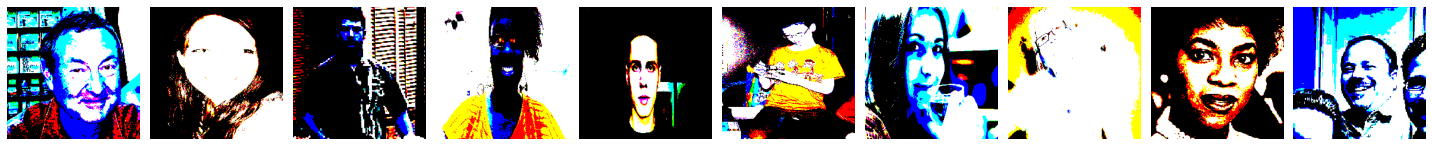

In [10]:
plotImages(imgs)

In [11]:
print(labels)

[55.46153846 33.12162162 23.70833333 22.92307692 24.64285714  9.76923077
 19.92307692 63.14285714 33.         45.23076923 25.48275862 48.58974359
  4.15       52.15384615 50.14285714 12.66666667 25.26086957 50.61290323
 24.30769231 20.15686275 54.21428571 24.         29.33333333 17.89473684
 24.61538462 37.69230769 27.84615385 28.94915254 37.5862069  31.46153846
 60.61111111 36.07692308 33.53846154 32.2        25.85714286 25.28571429
 26.5        37.2        25.38461538 16.83116883 25.         26.5
 46.95555556 19.15384615 24.75700935 24.10416667 31.3968254  52.23076923
 25.23076923  5.1025641  23.55405405  2.         21.28888889 55.26666667
 68.05405405 25.21428571 25.07692308 55.         39.          4.5
 22.         28.8974359  66.14285714 24.26086957]


In [12]:
vgg16_model = VGG16()

In [13]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model = keras.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [16]:
if not LAST_TRAINABLE_LAYERS:
    for layer in model.layers:
        layer.trainable = False
else:
    print(f"Setting trainable layers to {LAST_TRAINABLE_LAYERS}")
    for layer in vgg16_model.layers[:-LAST_TRAINABLE_LAYERS]:
        layer.trainable = False
        print(layer)

Setting trainable layers to 8


In [17]:
model.add(Dense(units=1))

In [18]:
# for layer in model.layers[14:]: 
#    print(f"{layer}: {layer.trainable}")
#    layer.trainable = True 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mean_absolute_error", metrics=[MeanAbsoluteError()])


In [20]:
model.fit(x=train_gen,steps_per_epoch=len(train_gen),validation_data=valid_gen, validation_steps=len(valid_gen), epochs=50, verbose=2, callbacks=[tensorboard_callback])

Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


KeyboardInterrupt: 

In [ ]:
image_path = '../data/regression/train/Profile.jpg'
plt.imread(image_path)
plt.show()


In [ ]:
img = image.load_img(image_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)


prediction = model.predict(img_preprocessed)

print(prediction)